# Notebook 14:  Ising Phases using Convolutional Neural Networks in PyTorch 

## Learning Goal
The primary goal of this notebooks is to learn how to implement a Convolutional Neural Network (CNN) using the powerful PyTorch package. It also introduces core concepts for CNNs such as convolutional and pooling layers and padding.

## Overview
In this notebook, we will write a simple convolutional neural network (CNN) in Pytorch for classifying phases for the Ising Model. We will consider perhaps the simplest CNN: a single convolutional layer with depth $N \in \{1,5,10,20,50\}$. This will introduce the power of the Pytorch framework to make dynamic graphs. 

We will use this notebook to characterize samples drawn from the 2D Ising model at various temperatures. This is the same dataset that has been used in all earlier examples. Recall that the critical temperature for the Ising model is $T_c=2.26$.

In [1]:
from __future__ import print_function, division
import os,sys
import numpy as np
import torch # pytorch package, allows using GPUs
# fix seed
seed=17
np.random.seed(seed)
torch.manual_seed(seed)

## Structure of the Procedure

Constructing a Deep Neural Network to solve ML problems is a multiple-stage process. Quite generally, one can identify the key steps as follows:

* ***step 1:*** Load and process the data
* ***step 2:*** Define the model and its architecture
* ***step 3:*** Choose the optimizer and the cost function
* ***step 4:*** Train the model 
* ***step 5:*** Evaluate the model performance on the *unseen* test data
* ***step 6:*** Modify the hyperparameters to optimize performance for the specific data set

Below, we sometimes combine some of these steps together for convenience.

### Step 1: Load and Process the Ising Dataset

We start by defining the dataset class for Pytorch.

We have three types of samples in the Ising dataset: samples drawn from deep in the disordered phase, samples drawn from the ordered phase, and samples drawn from near the critical phase which we do not use for training. The goal is to classify whether a sample comes from $T>T_c$ or $T<T_c$.

There is standard way to load data when using the PyTorch package, which we discussed in the DNN example for the SUSY dataset. Here, we just switch to the 2D-Ising data instead.

To proceed, download the Ising dataset and insert the proper `path_to_data` in the script.

In [2]:
from torchvision import datasets # load data

class Ising_Dataset(torch.utils.data.Dataset):
    """Ising pytorch dataset."""

    def __init__(self, data_type, transform=False):
        """
        Args:
            data_type (string): `train`, `test` or `critical`: creates data_loader
            transform (callable, optional): Optional transform to be applied on a sample.

        """

        from sklearn.model_selection import train_test_split
        import collections
        import pickle as pickle


        L=40 # linear system size
        T=np.linspace(0.25,4.0,16) # temperatures
        T_c=2.26 # critical temperature in the TD limit

        # path to data directory
        path_to_data=os.path.expanduser('~')+'/Dropbox/MachineLearningReview/Datasets/isingMC/'

        # load data
        file_name = "Ising2DFM_reSample_L40_T=All.pkl" # this file contains 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25)
        data = pickle.load(open(path_to_data+file_name,'rb')) # pickle reads the file and returns the Python object (1D array, compressed bits)
        data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
        data=data.astype('int')
        data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

        file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl" # this file contains 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25)
        labels = pickle.load(open(path_to_data+file_name,'rb')) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)

        # divide data into ordered, critical and disordered

        X_ordered=data[:70000,:]
        Y_ordered=labels[:70000]

        X_critical=data[70000:100000,:]
        Y_critical=labels[70000:100000]

        X_disordered=data[100000:,:]
        Y_disordered=labels[100000:]

        del data,labels
        # define training, critical and test data sets
        X=np.concatenate((X_ordered,X_disordered)) #np.concatenate((X_ordered,X_critical,X_disordered))
        Y=np.concatenate((Y_ordered,Y_disordered)) #np.concatenate((Y_ordered,Y_critical,Y_disordered))

        # pick random data points from ordered and disordered states to create the training and test sets
        X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,train_size=0.8)


        if data_type=='train':
            X=X_train
            Y=Y_train
            print("Training on 80 percent of examples")

        if data_type=='test':
            X=X_test
            Y=Y_test
            print("Testing on 20 percent of examples")

        if data_type=='critical':
            X=X_critical
            Y=Y_critical
            print("Predicting on %i critical examples"%len(Y_critical))

        # reshape data back to original 2D-array form
        X=X.reshape(X.shape[0],40,40)

        # these are necessary attributes in dataset class and must be assigned
        self.data=(X,Y)
        self.transform = transform


    # override __len__ and __getitem__ of the Dataset() class

    def __len__(self):
        return len(self.data[1])

    def __getitem__(self, idx):

        sample=(self.data[0][idx,...],self.data[1][idx])
        if self.transform:
            sample=self.transform(sample)

        return sample

    
def load_data(kwargs):
    # kwargs:  CUDA arguments, if enabled
    # load and noralise train,test, and data
    train_loader = torch.utils.data.DataLoader(
        Ising_Dataset(data_type='train'),
        batch_size=args.batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        Ising_Dataset(data_type='test'),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    critical_loader = torch.utils.data.DataLoader(
        Ising_Dataset(data_type='critical'),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    return train_loader, test_loader, critical_loader

### Step 2: Define the Neural Net and its Architecture

Similar to the discussion in the SUSY DNN notebook, we then define the architecture of the neural net in the `model` class which contains the `forward` function method that tells us how to produce the output given some input. The backpropagaiton algorithm is implemented automatically by the Pytorch package.

Recall that a CNN is composed of convolutional layers, max-pool layer, often followed by a fully connected layer and then the classifier. In the architecture below, we start with a convolutional layer that takes as an input a layer with $D_{in}=1$ with height and width $H=W=40$, a receptive field or filter size of $2 \times 2$, and depth $N$ (there are $N$ layers). We also add a padding of zeros on both sides of the image.  This convolutional layer can be summarized by the four numbers $[N,D_{in},H,W]=[N,1,41,41]$. This is then fed into a $2 \times 2$ maxpool layer which results in layer of size $[N,1,20,20]$. This layer is then hooked up to a linear layer that takes as an `[input,output]` of the form `[N*20*20*1,2]` since there are $2$ classes (corresponding to the ordered and disordered phases). We use a logistic (softmax) classifier as the output and train using various optimizers.

In [3]:
import torch.nn as nn # construct NN

class model(nn.Module):
    # create convolutional net
    def __init__(self, N=10, L=40):
        # inherit attributes and methods of nn.Module
        super(model, self).__init__()	
        # create convolutional layer with input depth 1 and output depth N
        self.conv1 = nn.Conv2d(1, N, kernel_size=2, padding=1)
        # batch norm layer takes Depth
        self.bn1=nn.BatchNorm2d(N) 
        # create fully connected layer after maxpool operation reduced 40->18
        self.fc1 = nn.Linear(20*20*N, 2) 	
        self.N=N
        self.L=L
        print("The number of neurons in CNN layer is %i"%(N))

    def forward(self, x):
        #Unsqueeze command indicates one channel and turns x.shape from (:,40,40) to (:,1, 40,40)
        x=F.relu(self.conv1(torch.unsqueeze(x,1).float()))
        #print(x.shape)  often useful to look at shapes for debugging
        x = F.max_pool2d(x,2)	 
        #print(x.shape)
        x=self.bn1(x) # largely unnecessary and here just for pedagogical purposes
        return F.log_softmax(self.fc1(x.view(-1,20*20*self.N)), dim=1)

#### Define the `train` and `test` functions

These are very standard functions for going over data to train and evaluate the model. 

Since we will be testing the CNN performance on both the test and the critical data, the `test` function accepts two arguments: `data_loader` and `verbose` to allow control over the input data and the printing messages.

In [4]:
def train(epoch):
    # these are very standard functions for going over data to train

    CNN.train() # effects Dropout and BatchNorm layers
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = CNN(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(data_loader,verbose='Test'):
    # these are very standard functions for evaluating data

    CNN.eval() # effects Dropout and BatchNorm layers
    test_loss = 0
    correct = 0
    for data, target in data_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        output = CNN(data)
        test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(data_loader.dataset)
    print('\n'+verbose+' set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    accuracy=100. * correct / len(data_loader.dataset)
    return(accuracy)

#### Define Model Parameters

Next we define the training settings. This proceeds in the same way as in Notebook 13 on the SUSY dataset, except we now also show how to turn on the `cuda` library option of PyTorch which enables parallel coputations (whenever resources for this are available). 

In [5]:
import argparse # handles arguments
import sys; sys.argv=['']; del sys # required to use parser in jupyter notebooks

# training settings
parser = argparse.ArgumentParser(description='PyTorch Convmodel Ising Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()
args.epochs=5
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

cuda_kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

### Steps 3+4+5: Choose the Optimizer and the Cost Function. Train and Evaluate the Model.

In [6]:
import torch.nn.functional as F # implements forward and backward definitions of an autograd operation
import torch.optim as optim # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc

# load data
train_loader, test_loader, critical_loader=load_data(cuda_kwargs)

test_array=[]
critical_array=[]

# create array of depth of convolutional layer
N_array=[1,5,10,20,50]

# loop over depths
for N in N_array:
    CNN = model(N=N)
    if args.cuda:
        CNN.cuda()

    # negative log-likelihood (nll) loss for training: takes class labels NOT one-hot vectors!
    criterion = F.nll_loss
    # define SGD optimizer
    optimizer = optim.SGD(CNN.parameters(), lr=args.lr, momentum=args.momentum)
    #optimizer = optim.Adam(DNN.parameters(), lr=0.001, betas=(0.9, 0.999))

    # train the CNN and test its performance at each epoch
    for epoch in range(1, args.epochs + 1):
        train(epoch)
        if epoch==args.epochs:
            test_array.append(test(test_loader,verbose='Test'))
            critical_array.append(test(critical_loader,verbose='Critical'))
        else:
            test(test_loader,verbose='Test')
            test(critical_loader,verbose='Critical')
    print(test_array)
    print(critical_array)

Training on 80 percent of examples
Testing on 20 percent of examples
Predicting on 30000 critical examples
The number of neurons in CNN layer is 1
Train Epoch: 1 [0/104000 (0%)]	Loss: 0.662742
Train Epoch: 1 [640/104000 (1%)]	Loss: 0.109889
Train Epoch: 1 [1280/104000 (1%)]	Loss: 0.045462
Train Epoch: 1 [1920/104000 (2%)]	Loss: 0.050722
Train Epoch: 1 [2560/104000 (2%)]	Loss: 0.020955
Train Epoch: 1 [3200/104000 (3%)]	Loss: 0.016692
Train Epoch: 1 [3840/104000 (4%)]	Loss: 0.019543
Train Epoch: 1 [4480/104000 (4%)]	Loss: 0.012761
Train Epoch: 1 [5120/104000 (5%)]	Loss: 0.017204
Train Epoch: 1 [5760/104000 (6%)]	Loss: 0.011533
Train Epoch: 1 [6400/104000 (6%)]	Loss: 0.007559
Train Epoch: 1 [7040/104000 (7%)]	Loss: 0.003841
Train Epoch: 1 [7680/104000 (7%)]	Loss: 0.004554
Train Epoch: 1 [8320/104000 (8%)]	Loss: 0.008697
Train Epoch: 1 [8960/104000 (9%)]	Loss: 0.005727
Train Epoch: 1 [9600/104000 (9%)]	Loss: 0.016714
Train Epoch: 1 [10240/104000 (10%)]	Loss: 0.002938
Train Epoch: 1 [10880/

Train Epoch: 1 [103680/104000 (100%)]	Loss: 0.000554


/Users/mgbukov/miniconda3/envs/mlreview/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0005, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.8165, Accuracy: 23875/30000 (80%)

Train Epoch: 2 [0/104000 (0%)]	Loss: 0.000207
Train Epoch: 2 [640/104000 (1%)]	Loss: 0.003293
Train Epoch: 2 [1280/104000 (1%)]	Loss: 0.002911
Train Epoch: 2 [1920/104000 (2%)]	Loss: 0.000456
Train Epoch: 2 [2560/104000 (2%)]	Loss: 0.000537
Train Epoch: 2 [3200/104000 (3%)]	Loss: 0.000169
Train Epoch: 2 [3840/104000 (4%)]	Loss: 0.004852
Train Epoch: 2 [4480/104000 (4%)]	Loss: 0.000377
Train Epoch: 2 [5120/104000 (5%)]	Loss: 0.000677
Train Epoch: 2 [5760/104000 (6%)]	Loss: 0.000874
Train Epoch: 2 [6400/104000 (6%)]	Loss: 0.000330
Train Epoch: 2 [7040/104000 (7%)]	Loss: 0.000055
Train Epoch: 2 [7680/104000 (7%)]	Loss: 0.000904
Train Epoch: 2 [8320/104000 (8%)]	Loss: 0.000891
Train Epoch: 2 [8960/104000 (9%)]	Loss: 0.001143
Train Epoch: 2 [9600/104000 (9%)]	Loss: 0.000845
Train Epoch: 2 [10240/104000 (10%)]	Loss: 0.000624
Train Epoch: 2 [10880/104000 (10%)]	Loss


Test set: Average loss: 0.0003, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.9904, Accuracy: 23634/30000 (79%)

Train Epoch: 3 [0/104000 (0%)]	Loss: 0.000187
Train Epoch: 3 [640/104000 (1%)]	Loss: 0.000054
Train Epoch: 3 [1280/104000 (1%)]	Loss: 0.000154
Train Epoch: 3 [1920/104000 (2%)]	Loss: 0.000851
Train Epoch: 3 [2560/104000 (2%)]	Loss: 0.000049
Train Epoch: 3 [3200/104000 (3%)]	Loss: 0.000274
Train Epoch: 3 [3840/104000 (4%)]	Loss: 0.000528
Train Epoch: 3 [4480/104000 (4%)]	Loss: 0.000440
Train Epoch: 3 [5120/104000 (5%)]	Loss: 0.001590
Train Epoch: 3 [5760/104000 (6%)]	Loss: 0.003739
Train Epoch: 3 [6400/104000 (6%)]	Loss: 0.000099
Train Epoch: 3 [7040/104000 (7%)]	Loss: 0.000564
Train Epoch: 3 [7680/104000 (7%)]	Loss: 0.000268
Train Epoch: 3 [8320/104000 (8%)]	Loss: 0.000250
Train Epoch: 3 [8960/104000 (9%)]	Loss: 0.000432
Train Epoch: 3 [9600/104000 (9%)]	Loss: 0.000188
Train Epoch: 3 [10240/104000 (10%)]	Loss: 0.000163
Train Epoch: 3 [10880/104000 (10%)]	Loss

Train Epoch: 3 [103680/104000 (100%)]	Loss: 0.000004

Test set: Average loss: 0.0000, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.3871, Accuracy: 25795/30000 (86%)

Train Epoch: 4 [0/104000 (0%)]	Loss: 0.000001
Train Epoch: 4 [640/104000 (1%)]	Loss: 0.000017
Train Epoch: 4 [1280/104000 (1%)]	Loss: 0.000013
Train Epoch: 4 [1920/104000 (2%)]	Loss: 0.000007
Train Epoch: 4 [2560/104000 (2%)]	Loss: 0.000003
Train Epoch: 4 [3200/104000 (3%)]	Loss: 0.000014
Train Epoch: 4 [3840/104000 (4%)]	Loss: 0.000000
Train Epoch: 4 [4480/104000 (4%)]	Loss: 0.000014
Train Epoch: 4 [5120/104000 (5%)]	Loss: 0.000003
Train Epoch: 4 [5760/104000 (6%)]	Loss: 0.000009
Train Epoch: 4 [6400/104000 (6%)]	Loss: 0.000011
Train Epoch: 4 [7040/104000 (7%)]	Loss: 0.000000
Train Epoch: 4 [7680/104000 (7%)]	Loss: 0.000046
Train Epoch: 4 [8320/104000 (8%)]	Loss: 0.000006
Train Epoch: 4 [8960/104000 (9%)]	Loss: 0.000004
Train Epoch: 4 [9600/104000 (9%)]	Loss: 0.000064
Train Epoch: 4 [10240/104000 (10%)]	Lo

Train Epoch: 4 [101760/104000 (98%)]	Loss: 0.000006
Train Epoch: 4 [102400/104000 (98%)]	Loss: 0.000001
Train Epoch: 4 [103040/104000 (99%)]	Loss: 0.000000
Train Epoch: 4 [103680/104000 (100%)]	Loss: 0.000006

Test set: Average loss: 0.0000, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.3498, Accuracy: 25909/30000 (86%)

Train Epoch: 5 [0/104000 (0%)]	Loss: 0.000037
Train Epoch: 5 [640/104000 (1%)]	Loss: 0.000001
Train Epoch: 5 [1280/104000 (1%)]	Loss: 0.000001
Train Epoch: 5 [1920/104000 (2%)]	Loss: 0.000003
Train Epoch: 5 [2560/104000 (2%)]	Loss: 0.000002
Train Epoch: 5 [3200/104000 (3%)]	Loss: 0.000003
Train Epoch: 5 [3840/104000 (4%)]	Loss: 0.000001
Train Epoch: 5 [4480/104000 (4%)]	Loss: 0.000009
Train Epoch: 5 [5120/104000 (5%)]	Loss: 0.000000
Train Epoch: 5 [5760/104000 (6%)]	Loss: 0.000002
Train Epoch: 5 [6400/104000 (6%)]	Loss: 0.000002
Train Epoch: 5 [7040/104000 (7%)]	Loss: 0.000004
Train Epoch: 5 [7680/104000 (7%)]	Loss: 0.000001
Train Epoch: 5 [8320/104000 (


Test set: Average loss: 0.0000, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.2745, Accuracy: 26568/30000 (89%)

[100.0]
[88.56]
The number of neurons in CNN layer is 5
Train Epoch: 1 [0/104000 (0%)]	Loss: 0.735635
Train Epoch: 1 [640/104000 (1%)]	Loss: 0.006729
Train Epoch: 1 [1280/104000 (1%)]	Loss: 0.008744
Train Epoch: 1 [1920/104000 (2%)]	Loss: 0.003856
Train Epoch: 1 [2560/104000 (2%)]	Loss: 0.002027
Train Epoch: 1 [3200/104000 (3%)]	Loss: 0.001791
Train Epoch: 1 [3840/104000 (4%)]	Loss: 0.001974
Train Epoch: 1 [4480/104000 (4%)]	Loss: 0.002818
Train Epoch: 1 [5120/104000 (5%)]	Loss: 0.001130
Train Epoch: 1 [5760/104000 (6%)]	Loss: 0.001281
Train Epoch: 1 [6400/104000 (6%)]	Loss: 0.001820
Train Epoch: 1 [7040/104000 (7%)]	Loss: 0.000577
Train Epoch: 1 [7680/104000 (7%)]	Loss: 0.002283
Train Epoch: 1 [8320/104000 (8%)]	Loss: 0.001235
Train Epoch: 1 [8960/104000 (9%)]	Loss: 0.000694
Train Epoch: 1 [9600/104000 (9%)]	Loss: 0.001370
Train Epoch: 1 [10240/104000 (10%)]

Train Epoch: 1 [101120/104000 (97%)]	Loss: 0.000055
Train Epoch: 1 [101760/104000 (98%)]	Loss: 0.000100
Train Epoch: 1 [102400/104000 (98%)]	Loss: 0.000185
Train Epoch: 1 [103040/104000 (99%)]	Loss: 0.000271
Train Epoch: 1 [103680/104000 (100%)]	Loss: 0.000036

Test set: Average loss: 0.0001, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.2616, Accuracy: 26099/30000 (87%)

Train Epoch: 2 [0/104000 (0%)]	Loss: 0.000091
Train Epoch: 2 [640/104000 (1%)]	Loss: 0.000039
Train Epoch: 2 [1280/104000 (1%)]	Loss: 0.000085
Train Epoch: 2 [1920/104000 (2%)]	Loss: 0.000152
Train Epoch: 2 [2560/104000 (2%)]	Loss: 0.000086
Train Epoch: 2 [3200/104000 (3%)]	Loss: 0.000064
Train Epoch: 2 [3840/104000 (4%)]	Loss: 0.000059
Train Epoch: 2 [4480/104000 (4%)]	Loss: 0.000649
Train Epoch: 2 [5120/104000 (5%)]	Loss: 0.000282
Train Epoch: 2 [5760/104000 (6%)]	Loss: 0.000036
Train Epoch: 2 [6400/104000 (6%)]	Loss: 0.000047
Train Epoch: 2 [7040/104000 (7%)]	Loss: 0.000039
Train Epoch: 2 [7680/10400

Train Epoch: 2 [99200/104000 (95%)]	Loss: 0.000043
Train Epoch: 2 [99840/104000 (96%)]	Loss: 0.000189
Train Epoch: 2 [100480/104000 (97%)]	Loss: 0.000012
Train Epoch: 2 [101120/104000 (97%)]	Loss: 0.000154
Train Epoch: 2 [101760/104000 (98%)]	Loss: 0.000015
Train Epoch: 2 [102400/104000 (98%)]	Loss: 0.000015
Train Epoch: 2 [103040/104000 (99%)]	Loss: 0.000222
Train Epoch: 2 [103680/104000 (100%)]	Loss: 0.000062

Test set: Average loss: 0.0000, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.2827, Accuracy: 25898/30000 (86%)

Train Epoch: 3 [0/104000 (0%)]	Loss: 0.000062
Train Epoch: 3 [640/104000 (1%)]	Loss: 0.000032
Train Epoch: 3 [1280/104000 (1%)]	Loss: 0.000027
Train Epoch: 3 [1920/104000 (2%)]	Loss: 0.000102
Train Epoch: 3 [2560/104000 (2%)]	Loss: 0.000049
Train Epoch: 3 [3200/104000 (3%)]	Loss: 0.000057
Train Epoch: 3 [3840/104000 (4%)]	Loss: 0.000086
Train Epoch: 3 [4480/104000 (4%)]	Loss: 0.000031
Train Epoch: 3 [5120/104000 (5%)]	Loss: 0.000087
Train Epoch: 3 [576

Train Epoch: 3 [97280/104000 (94%)]	Loss: 0.000012
Train Epoch: 3 [97920/104000 (94%)]	Loss: 0.000064
Train Epoch: 3 [98560/104000 (95%)]	Loss: 0.000007
Train Epoch: 3 [99200/104000 (95%)]	Loss: 0.000150
Train Epoch: 3 [99840/104000 (96%)]	Loss: 0.000035
Train Epoch: 3 [100480/104000 (97%)]	Loss: 0.000023
Train Epoch: 3 [101120/104000 (97%)]	Loss: 0.000030
Train Epoch: 3 [101760/104000 (98%)]	Loss: 0.000011
Train Epoch: 3 [102400/104000 (98%)]	Loss: 0.000008
Train Epoch: 3 [103040/104000 (99%)]	Loss: 0.000104
Train Epoch: 3 [103680/104000 (100%)]	Loss: 0.000076

Test set: Average loss: 0.0000, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.2302, Accuracy: 26714/30000 (89%)

Train Epoch: 4 [0/104000 (0%)]	Loss: 0.000044
Train Epoch: 4 [640/104000 (1%)]	Loss: 0.000011
Train Epoch: 4 [1280/104000 (1%)]	Loss: 0.000048
Train Epoch: 4 [1920/104000 (2%)]	Loss: 0.000016
Train Epoch: 4 [2560/104000 (2%)]	Loss: 0.000070
Train Epoch: 4 [3200/104000 (3%)]	Loss: 0.000233
Train Epoch: 

Train Epoch: 4 [96000/104000 (92%)]	Loss: 0.000014
Train Epoch: 4 [96640/104000 (93%)]	Loss: 0.000015
Train Epoch: 4 [97280/104000 (94%)]	Loss: 0.000606
Train Epoch: 4 [97920/104000 (94%)]	Loss: 0.000010
Train Epoch: 4 [98560/104000 (95%)]	Loss: 0.000019
Train Epoch: 4 [99200/104000 (95%)]	Loss: 0.000034
Train Epoch: 4 [99840/104000 (96%)]	Loss: 0.000071
Train Epoch: 4 [100480/104000 (97%)]	Loss: 0.000017
Train Epoch: 4 [101120/104000 (97%)]	Loss: 0.000009
Train Epoch: 4 [101760/104000 (98%)]	Loss: 0.000028
Train Epoch: 4 [102400/104000 (98%)]	Loss: 0.000041
Train Epoch: 4 [103040/104000 (99%)]	Loss: 0.000083
Train Epoch: 4 [103680/104000 (100%)]	Loss: 0.000031

Test set: Average loss: 0.0000, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.2675, Accuracy: 26228/30000 (87%)

Train Epoch: 5 [0/104000 (0%)]	Loss: 0.000007
Train Epoch: 5 [640/104000 (1%)]	Loss: 0.000041
Train Epoch: 5 [1280/104000 (1%)]	Loss: 0.000008
Train Epoch: 5 [1920/104000 (2%)]	Loss: 0.000036
Train Epo

Train Epoch: 5 [93440/104000 (90%)]	Loss: 0.000006
Train Epoch: 5 [94080/104000 (90%)]	Loss: 0.000015
Train Epoch: 5 [94720/104000 (91%)]	Loss: 0.000014
Train Epoch: 5 [95360/104000 (92%)]	Loss: 0.000018
Train Epoch: 5 [96000/104000 (92%)]	Loss: 0.000006
Train Epoch: 5 [96640/104000 (93%)]	Loss: 0.000009
Train Epoch: 5 [97280/104000 (94%)]	Loss: 0.000008
Train Epoch: 5 [97920/104000 (94%)]	Loss: 0.000025
Train Epoch: 5 [98560/104000 (95%)]	Loss: 0.000006
Train Epoch: 5 [99200/104000 (95%)]	Loss: 0.000008
Train Epoch: 5 [99840/104000 (96%)]	Loss: 0.000038
Train Epoch: 5 [100480/104000 (97%)]	Loss: 0.000004
Train Epoch: 5 [101120/104000 (97%)]	Loss: 0.000020
Train Epoch: 5 [101760/104000 (98%)]	Loss: 0.000006
Train Epoch: 5 [102400/104000 (98%)]	Loss: 0.000007
Train Epoch: 5 [103040/104000 (99%)]	Loss: 0.000044
Train Epoch: 5 [103680/104000 (100%)]	Loss: 0.000092

Test set: Average loss: 0.0000, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.1840, Accuracy: 27434/30000 (91%

Train Epoch: 1 [90240/104000 (87%)]	Loss: 0.000086
Train Epoch: 1 [90880/104000 (87%)]	Loss: 0.000078
Train Epoch: 1 [91520/104000 (88%)]	Loss: 0.000045
Train Epoch: 1 [92160/104000 (89%)]	Loss: 0.000104
Train Epoch: 1 [92800/104000 (89%)]	Loss: 0.000059
Train Epoch: 1 [93440/104000 (90%)]	Loss: 0.000071
Train Epoch: 1 [94080/104000 (90%)]	Loss: 0.000035
Train Epoch: 1 [94720/104000 (91%)]	Loss: 0.000094
Train Epoch: 1 [95360/104000 (92%)]	Loss: 0.000089
Train Epoch: 1 [96000/104000 (92%)]	Loss: 0.000071
Train Epoch: 1 [96640/104000 (93%)]	Loss: 0.000202
Train Epoch: 1 [97280/104000 (94%)]	Loss: 0.000061
Train Epoch: 1 [97920/104000 (94%)]	Loss: 0.000074
Train Epoch: 1 [98560/104000 (95%)]	Loss: 0.000062
Train Epoch: 1 [99200/104000 (95%)]	Loss: 0.000194
Train Epoch: 1 [99840/104000 (96%)]	Loss: 0.000070
Train Epoch: 1 [100480/104000 (97%)]	Loss: 0.000037
Train Epoch: 1 [101120/104000 (97%)]	Loss: 0.000226
Train Epoch: 1 [101760/104000 (98%)]	Loss: 0.000044
Train Epoch: 1 [102400/10400

Train Epoch: 2 [87680/104000 (84%)]	Loss: 0.000039
Train Epoch: 2 [88320/104000 (85%)]	Loss: 0.000042
Train Epoch: 2 [88960/104000 (86%)]	Loss: 0.000021
Train Epoch: 2 [89600/104000 (86%)]	Loss: 0.000062
Train Epoch: 2 [90240/104000 (87%)]	Loss: 0.000053
Train Epoch: 2 [90880/104000 (87%)]	Loss: 0.000026
Train Epoch: 2 [91520/104000 (88%)]	Loss: 0.000050
Train Epoch: 2 [92160/104000 (89%)]	Loss: 0.000041
Train Epoch: 2 [92800/104000 (89%)]	Loss: 0.000024
Train Epoch: 2 [93440/104000 (90%)]	Loss: 0.000024
Train Epoch: 2 [94080/104000 (90%)]	Loss: 0.000011
Train Epoch: 2 [94720/104000 (91%)]	Loss: 0.000027
Train Epoch: 2 [95360/104000 (92%)]	Loss: 0.000136
Train Epoch: 2 [96000/104000 (92%)]	Loss: 0.000015
Train Epoch: 2 [96640/104000 (93%)]	Loss: 0.000066
Train Epoch: 2 [97280/104000 (94%)]	Loss: 0.000221
Train Epoch: 2 [97920/104000 (94%)]	Loss: 0.000067
Train Epoch: 2 [98560/104000 (95%)]	Loss: 0.000014
Train Epoch: 2 [99200/104000 (95%)]	Loss: 0.000091
Train Epoch: 2 [99840/104000 (9

Train Epoch: 3 [85120/104000 (82%)]	Loss: 0.000012
Train Epoch: 3 [85760/104000 (82%)]	Loss: 0.000045
Train Epoch: 3 [86400/104000 (83%)]	Loss: 0.000017
Train Epoch: 3 [87040/104000 (84%)]	Loss: 0.000027
Train Epoch: 3 [87680/104000 (84%)]	Loss: 0.000012
Train Epoch: 3 [88320/104000 (85%)]	Loss: 0.000058
Train Epoch: 3 [88960/104000 (86%)]	Loss: 0.000018
Train Epoch: 3 [89600/104000 (86%)]	Loss: 0.000019
Train Epoch: 3 [90240/104000 (87%)]	Loss: 0.000014
Train Epoch: 3 [90880/104000 (87%)]	Loss: 0.000009
Train Epoch: 3 [91520/104000 (88%)]	Loss: 0.000008
Train Epoch: 3 [92160/104000 (89%)]	Loss: 0.000008
Train Epoch: 3 [92800/104000 (89%)]	Loss: 0.000094
Train Epoch: 3 [93440/104000 (90%)]	Loss: 0.000103
Train Epoch: 3 [94080/104000 (90%)]	Loss: 0.000040
Train Epoch: 3 [94720/104000 (91%)]	Loss: 0.000068
Train Epoch: 3 [95360/104000 (92%)]	Loss: 0.000033
Train Epoch: 3 [96000/104000 (92%)]	Loss: 0.000008
Train Epoch: 3 [96640/104000 (93%)]	Loss: 0.000018
Train Epoch: 3 [97280/104000 (9

Train Epoch: 4 [82560/104000 (79%)]	Loss: 0.000019
Train Epoch: 4 [83200/104000 (80%)]	Loss: 0.000036
Train Epoch: 4 [83840/104000 (81%)]	Loss: 0.000004
Train Epoch: 4 [84480/104000 (81%)]	Loss: 0.000112
Train Epoch: 4 [85120/104000 (82%)]	Loss: 0.000016
Train Epoch: 4 [85760/104000 (82%)]	Loss: 0.000007
Train Epoch: 4 [86400/104000 (83%)]	Loss: 0.000023
Train Epoch: 4 [87040/104000 (84%)]	Loss: 0.000045
Train Epoch: 4 [87680/104000 (84%)]	Loss: 0.000008
Train Epoch: 4 [88320/104000 (85%)]	Loss: 0.000012
Train Epoch: 4 [88960/104000 (86%)]	Loss: 0.000013
Train Epoch: 4 [89600/104000 (86%)]	Loss: 0.000023
Train Epoch: 4 [90240/104000 (87%)]	Loss: 0.000009
Train Epoch: 4 [90880/104000 (87%)]	Loss: 0.000028
Train Epoch: 4 [91520/104000 (88%)]	Loss: 0.000011
Train Epoch: 4 [92160/104000 (89%)]	Loss: 0.000034
Train Epoch: 4 [92800/104000 (89%)]	Loss: 0.000008
Train Epoch: 4 [93440/104000 (90%)]	Loss: 0.000011
Train Epoch: 4 [94080/104000 (90%)]	Loss: 0.000192
Train Epoch: 4 [94720/104000 (9

Train Epoch: 5 [80640/104000 (78%)]	Loss: 0.000010
Train Epoch: 5 [81280/104000 (78%)]	Loss: 0.000005
Train Epoch: 5 [81920/104000 (79%)]	Loss: 0.000016
Train Epoch: 5 [82560/104000 (79%)]	Loss: 0.000016
Train Epoch: 5 [83200/104000 (80%)]	Loss: 0.000031
Train Epoch: 5 [83840/104000 (81%)]	Loss: 0.000007
Train Epoch: 5 [84480/104000 (81%)]	Loss: 0.000036
Train Epoch: 5 [85120/104000 (82%)]	Loss: 0.000009
Train Epoch: 5 [85760/104000 (82%)]	Loss: 0.000003
Train Epoch: 5 [86400/104000 (83%)]	Loss: 0.000023
Train Epoch: 5 [87040/104000 (84%)]	Loss: 0.000134
Train Epoch: 5 [87680/104000 (84%)]	Loss: 0.000017
Train Epoch: 5 [88320/104000 (85%)]	Loss: 0.000004
Train Epoch: 5 [88960/104000 (86%)]	Loss: 0.000014
Train Epoch: 5 [89600/104000 (86%)]	Loss: 0.000060
Train Epoch: 5 [90240/104000 (87%)]	Loss: 0.000010
Train Epoch: 5 [90880/104000 (87%)]	Loss: 0.000008
Train Epoch: 5 [91520/104000 (88%)]	Loss: 0.000006
Train Epoch: 5 [92160/104000 (89%)]	Loss: 0.000013
Train Epoch: 5 [92800/104000 (8

Train Epoch: 1 [76800/104000 (74%)]	Loss: 0.000050
Train Epoch: 1 [77440/104000 (74%)]	Loss: 0.000067
Train Epoch: 1 [78080/104000 (75%)]	Loss: 0.000064
Train Epoch: 1 [78720/104000 (76%)]	Loss: 0.000075
Train Epoch: 1 [79360/104000 (76%)]	Loss: 0.000049
Train Epoch: 1 [80000/104000 (77%)]	Loss: 0.000106
Train Epoch: 1 [80640/104000 (78%)]	Loss: 0.000031
Train Epoch: 1 [81280/104000 (78%)]	Loss: 0.000327
Train Epoch: 1 [81920/104000 (79%)]	Loss: 0.000087
Train Epoch: 1 [82560/104000 (79%)]	Loss: 0.000025
Train Epoch: 1 [83200/104000 (80%)]	Loss: 0.000041
Train Epoch: 1 [83840/104000 (81%)]	Loss: 0.000026
Train Epoch: 1 [84480/104000 (81%)]	Loss: 0.000110
Train Epoch: 1 [85120/104000 (82%)]	Loss: 0.000016
Train Epoch: 1 [85760/104000 (82%)]	Loss: 0.000031
Train Epoch: 1 [86400/104000 (83%)]	Loss: 0.000027
Train Epoch: 1 [87040/104000 (84%)]	Loss: 0.000044
Train Epoch: 1 [87680/104000 (84%)]	Loss: 0.000048
Train Epoch: 1 [88320/104000 (85%)]	Loss: 0.000054
Train Epoch: 1 [88960/104000 (8

Train Epoch: 2 [74240/104000 (71%)]	Loss: 0.000061
Train Epoch: 2 [74880/104000 (72%)]	Loss: 0.000019
Train Epoch: 2 [75520/104000 (73%)]	Loss: 0.000027
Train Epoch: 2 [76160/104000 (73%)]	Loss: 0.000077
Train Epoch: 2 [76800/104000 (74%)]	Loss: 0.000009
Train Epoch: 2 [77440/104000 (74%)]	Loss: 0.000010
Train Epoch: 2 [78080/104000 (75%)]	Loss: 0.000012
Train Epoch: 2 [78720/104000 (76%)]	Loss: 0.000013
Train Epoch: 2 [79360/104000 (76%)]	Loss: 0.000029
Train Epoch: 2 [80000/104000 (77%)]	Loss: 0.000015
Train Epoch: 2 [80640/104000 (78%)]	Loss: 0.000034
Train Epoch: 2 [81280/104000 (78%)]	Loss: 0.000028
Train Epoch: 2 [81920/104000 (79%)]	Loss: 0.000027
Train Epoch: 2 [82560/104000 (79%)]	Loss: 0.000008
Train Epoch: 2 [83200/104000 (80%)]	Loss: 0.000008
Train Epoch: 2 [83840/104000 (81%)]	Loss: 0.000009
Train Epoch: 2 [84480/104000 (81%)]	Loss: 0.000221
Train Epoch: 2 [85120/104000 (82%)]	Loss: 0.000295
Train Epoch: 2 [85760/104000 (82%)]	Loss: 0.000021
Train Epoch: 2 [86400/104000 (8

Train Epoch: 3 [71680/104000 (69%)]	Loss: 0.000021
Train Epoch: 3 [72320/104000 (70%)]	Loss: 0.000011
Train Epoch: 3 [72960/104000 (70%)]	Loss: 0.000006
Train Epoch: 3 [73600/104000 (71%)]	Loss: 0.000006
Train Epoch: 3 [74240/104000 (71%)]	Loss: 0.000035
Train Epoch: 3 [74880/104000 (72%)]	Loss: 0.000010
Train Epoch: 3 [75520/104000 (73%)]	Loss: 0.000009
Train Epoch: 3 [76160/104000 (73%)]	Loss: 0.000009
Train Epoch: 3 [76800/104000 (74%)]	Loss: 0.000086
Train Epoch: 3 [77440/104000 (74%)]	Loss: 0.000047
Train Epoch: 3 [78080/104000 (75%)]	Loss: 0.000012
Train Epoch: 3 [78720/104000 (76%)]	Loss: 0.000030
Train Epoch: 3 [79360/104000 (76%)]	Loss: 0.000054
Train Epoch: 3 [80000/104000 (77%)]	Loss: 0.000047
Train Epoch: 3 [80640/104000 (78%)]	Loss: 0.000015
Train Epoch: 3 [81280/104000 (78%)]	Loss: 0.000043
Train Epoch: 3 [81920/104000 (79%)]	Loss: 0.000006
Train Epoch: 3 [82560/104000 (79%)]	Loss: 0.000030
Train Epoch: 3 [83200/104000 (80%)]	Loss: 0.000012
Train Epoch: 3 [83840/104000 (8

Train Epoch: 4 [69120/104000 (66%)]	Loss: 0.000015
Train Epoch: 4 [69760/104000 (67%)]	Loss: 0.000004
Train Epoch: 4 [70400/104000 (68%)]	Loss: 0.000012
Train Epoch: 4 [71040/104000 (68%)]	Loss: 0.000024
Train Epoch: 4 [71680/104000 (69%)]	Loss: 0.000081
Train Epoch: 4 [72320/104000 (70%)]	Loss: 0.000004
Train Epoch: 4 [72960/104000 (70%)]	Loss: 0.000009
Train Epoch: 4 [73600/104000 (71%)]	Loss: 0.000017
Train Epoch: 4 [74240/104000 (71%)]	Loss: 0.000035
Train Epoch: 4 [74880/104000 (72%)]	Loss: 0.000089
Train Epoch: 4 [75520/104000 (73%)]	Loss: 0.000005
Train Epoch: 4 [76160/104000 (73%)]	Loss: 0.000008
Train Epoch: 4 [76800/104000 (74%)]	Loss: 0.000008
Train Epoch: 4 [77440/104000 (74%)]	Loss: 0.000010
Train Epoch: 4 [78080/104000 (75%)]	Loss: 0.000013
Train Epoch: 4 [78720/104000 (76%)]	Loss: 0.000014
Train Epoch: 4 [79360/104000 (76%)]	Loss: 0.000064
Train Epoch: 4 [80000/104000 (77%)]	Loss: 0.000233
Train Epoch: 4 [80640/104000 (78%)]	Loss: 0.000006
Train Epoch: 4 [81280/104000 (7

Train Epoch: 5 [66560/104000 (64%)]	Loss: 0.000004
Train Epoch: 5 [67200/104000 (65%)]	Loss: 0.000054
Train Epoch: 5 [67840/104000 (65%)]	Loss: 0.000040
Train Epoch: 5 [68480/104000 (66%)]	Loss: 0.000004
Train Epoch: 5 [69120/104000 (66%)]	Loss: 0.000003
Train Epoch: 5 [69760/104000 (67%)]	Loss: 0.000023
Train Epoch: 5 [70400/104000 (68%)]	Loss: 0.000005
Train Epoch: 5 [71040/104000 (68%)]	Loss: 0.000037
Train Epoch: 5 [71680/104000 (69%)]	Loss: 0.000005
Train Epoch: 5 [72320/104000 (70%)]	Loss: 0.000007
Train Epoch: 5 [72960/104000 (70%)]	Loss: 0.000005
Train Epoch: 5 [73600/104000 (71%)]	Loss: 0.000004
Train Epoch: 5 [74240/104000 (71%)]	Loss: 0.000008
Train Epoch: 5 [74880/104000 (72%)]	Loss: 0.000015
Train Epoch: 5 [75520/104000 (73%)]	Loss: 0.000004
Train Epoch: 5 [76160/104000 (73%)]	Loss: 0.000005
Train Epoch: 5 [76800/104000 (74%)]	Loss: 0.000004
Train Epoch: 5 [77440/104000 (74%)]	Loss: 0.000003
Train Epoch: 5 [78080/104000 (75%)]	Loss: 0.000013
Train Epoch: 5 [78720/104000 (7

Train Epoch: 1 [62720/104000 (60%)]	Loss: 0.000000
Train Epoch: 1 [63360/104000 (61%)]	Loss: 0.000000
Train Epoch: 1 [64000/104000 (62%)]	Loss: 0.000000
Train Epoch: 1 [64640/104000 (62%)]	Loss: 0.000000
Train Epoch: 1 [65280/104000 (63%)]	Loss: 0.000000
Train Epoch: 1 [65920/104000 (63%)]	Loss: 0.000000
Train Epoch: 1 [66560/104000 (64%)]	Loss: 0.000000
Train Epoch: 1 [67200/104000 (65%)]	Loss: 0.000000
Train Epoch: 1 [67840/104000 (65%)]	Loss: 0.000000
Train Epoch: 1 [68480/104000 (66%)]	Loss: 0.000000
Train Epoch: 1 [69120/104000 (66%)]	Loss: 0.000000
Train Epoch: 1 [69760/104000 (67%)]	Loss: 0.000000
Train Epoch: 1 [70400/104000 (68%)]	Loss: 0.000000
Train Epoch: 1 [71040/104000 (68%)]	Loss: 0.000000
Train Epoch: 1 [71680/104000 (69%)]	Loss: 0.000000
Train Epoch: 1 [72320/104000 (70%)]	Loss: 0.000000
Train Epoch: 1 [72960/104000 (70%)]	Loss: 0.000000
Train Epoch: 1 [73600/104000 (71%)]	Loss: 0.000003
Train Epoch: 1 [74240/104000 (71%)]	Loss: 0.000000
Train Epoch: 1 [74880/104000 (7

Train Epoch: 2 [60160/104000 (58%)]	Loss: 0.000000
Train Epoch: 2 [60800/104000 (58%)]	Loss: 0.000000
Train Epoch: 2 [61440/104000 (59%)]	Loss: 0.000000
Train Epoch: 2 [62080/104000 (60%)]	Loss: 0.000000
Train Epoch: 2 [62720/104000 (60%)]	Loss: 0.000000
Train Epoch: 2 [63360/104000 (61%)]	Loss: 0.000000
Train Epoch: 2 [64000/104000 (62%)]	Loss: 0.000000
Train Epoch: 2 [64640/104000 (62%)]	Loss: 0.000000
Train Epoch: 2 [65280/104000 (63%)]	Loss: 0.000000
Train Epoch: 2 [65920/104000 (63%)]	Loss: 0.000000
Train Epoch: 2 [66560/104000 (64%)]	Loss: 0.000000
Train Epoch: 2 [67200/104000 (65%)]	Loss: 0.000000
Train Epoch: 2 [67840/104000 (65%)]	Loss: 0.000000
Train Epoch: 2 [68480/104000 (66%)]	Loss: 0.000000
Train Epoch: 2 [69120/104000 (66%)]	Loss: 0.000000
Train Epoch: 2 [69760/104000 (67%)]	Loss: 0.000000
Train Epoch: 2 [70400/104000 (68%)]	Loss: 0.000000
Train Epoch: 2 [71040/104000 (68%)]	Loss: 0.000000
Train Epoch: 2 [71680/104000 (69%)]	Loss: 0.000000
Train Epoch: 2 [72320/104000 (7

Train Epoch: 3 [57600/104000 (55%)]	Loss: 0.000000
Train Epoch: 3 [58240/104000 (56%)]	Loss: 0.000000
Train Epoch: 3 [58880/104000 (57%)]	Loss: 0.000000
Train Epoch: 3 [59520/104000 (57%)]	Loss: 0.000000
Train Epoch: 3 [60160/104000 (58%)]	Loss: 0.000000
Train Epoch: 3 [60800/104000 (58%)]	Loss: 0.000000
Train Epoch: 3 [61440/104000 (59%)]	Loss: 0.000000
Train Epoch: 3 [62080/104000 (60%)]	Loss: 0.000000
Train Epoch: 3 [62720/104000 (60%)]	Loss: 0.000000
Train Epoch: 3 [63360/104000 (61%)]	Loss: 0.000552
Train Epoch: 3 [64000/104000 (62%)]	Loss: 0.000000
Train Epoch: 3 [64640/104000 (62%)]	Loss: 0.000000
Train Epoch: 3 [65280/104000 (63%)]	Loss: 0.000000
Train Epoch: 3 [65920/104000 (63%)]	Loss: 0.000000
Train Epoch: 3 [66560/104000 (64%)]	Loss: 0.000000
Train Epoch: 3 [67200/104000 (65%)]	Loss: 0.000000
Train Epoch: 3 [67840/104000 (65%)]	Loss: 0.000000
Train Epoch: 3 [68480/104000 (66%)]	Loss: 0.000000
Train Epoch: 3 [69120/104000 (66%)]	Loss: 0.000000
Train Epoch: 3 [69760/104000 (6

Train Epoch: 4 [55040/104000 (53%)]	Loss: 0.000000
Train Epoch: 4 [55680/104000 (54%)]	Loss: 0.000000
Train Epoch: 4 [56320/104000 (54%)]	Loss: 0.000000
Train Epoch: 4 [56960/104000 (55%)]	Loss: 0.000000
Train Epoch: 4 [57600/104000 (55%)]	Loss: 0.000003
Train Epoch: 4 [58240/104000 (56%)]	Loss: 0.000000
Train Epoch: 4 [58880/104000 (57%)]	Loss: 0.000000
Train Epoch: 4 [59520/104000 (57%)]	Loss: 0.000000
Train Epoch: 4 [60160/104000 (58%)]	Loss: 0.000000
Train Epoch: 4 [60800/104000 (58%)]	Loss: 0.000000
Train Epoch: 4 [61440/104000 (59%)]	Loss: 0.000000
Train Epoch: 4 [62080/104000 (60%)]	Loss: 0.000000
Train Epoch: 4 [62720/104000 (60%)]	Loss: 0.000000
Train Epoch: 4 [63360/104000 (61%)]	Loss: 0.000000
Train Epoch: 4 [64000/104000 (62%)]	Loss: 0.000000
Train Epoch: 4 [64640/104000 (62%)]	Loss: 0.000000
Train Epoch: 4 [65280/104000 (63%)]	Loss: 0.000000
Train Epoch: 4 [65920/104000 (63%)]	Loss: 0.000000
Train Epoch: 4 [66560/104000 (64%)]	Loss: 0.000000
Train Epoch: 4 [67200/104000 (6

Train Epoch: 5 [52480/104000 (50%)]	Loss: 0.000000
Train Epoch: 5 [53120/104000 (51%)]	Loss: 0.000000
Train Epoch: 5 [53760/104000 (52%)]	Loss: 0.000000
Train Epoch: 5 [54400/104000 (52%)]	Loss: 0.000000
Train Epoch: 5 [55040/104000 (53%)]	Loss: 0.000000
Train Epoch: 5 [55680/104000 (54%)]	Loss: 0.000000
Train Epoch: 5 [56320/104000 (54%)]	Loss: 0.000000
Train Epoch: 5 [56960/104000 (55%)]	Loss: 0.000000
Train Epoch: 5 [57600/104000 (55%)]	Loss: 0.000000
Train Epoch: 5 [58240/104000 (56%)]	Loss: 0.000000
Train Epoch: 5 [58880/104000 (57%)]	Loss: 0.000000
Train Epoch: 5 [59520/104000 (57%)]	Loss: 0.000000
Train Epoch: 5 [60160/104000 (58%)]	Loss: 0.000000
Train Epoch: 5 [60800/104000 (58%)]	Loss: 0.000000
Train Epoch: 5 [61440/104000 (59%)]	Loss: 0.000000
Train Epoch: 5 [62080/104000 (60%)]	Loss: 0.000000
Train Epoch: 5 [62720/104000 (60%)]	Loss: 0.000000
Train Epoch: 5 [63360/104000 (61%)]	Loss: 0.000000
Train Epoch: 5 [64000/104000 (62%)]	Loss: 0.000000
Train Epoch: 5 [64640/104000 (6

## Plot Accuracy

Let us now plot the accuracy of our calculation. Notice that even with a convolutional layer of depth 1 (one set of weights and a single bias!) we can get a 100% accuracy on the test set. We do less well on the critical data (somewhere between 80-90%) with lots of fluctuations from training run to training to run. Again, this shows you the incredible power and (some of the limitations) of all these ML methods. If the dataset we care about (critical region) is not exactly the dataset we train on, our accuracy can be significantly diminished.

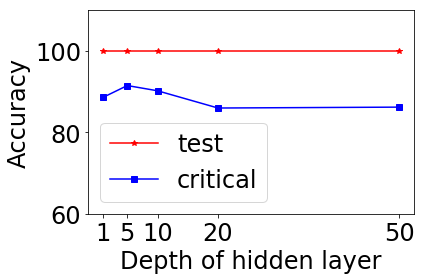

In [7]:
from matplotlib import pyplot as plt

## Print the result for different N
%matplotlib inline

plt.plot(N_array, test_array, 'r-*', label="test")
plt.plot(N_array, critical_array, 'b-s', label="critical")
plt.ylim(60,110)
plt.xlabel('Depth of hidden layer', fontsize=24)
plt.xticks(N_array)
plt.ylabel('Accuracy', fontsize=24)
plt.legend(loc='best', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.tight_layout()
plt.show()

## Exercises

* Do __Step 6__: modify the hyperparameters to optimize performance for the specific data set
* The strides used above do not account for the periodic boundary conditions. Define your own stride function in PyTorch to incorporate periodic boundary conditions